In [110]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso, LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
import scipy.special

# NLSYM DATA

In [112]:
# Preprocess data
df = pd.read_csv("data/card.csv")
data_filter = df['educ'].values >= 6
T = df['educ'].values[data_filter]
Z = df['nearc4'].values[data_filter]
y = df['lwage'].values[data_filter]

# Impute missing values with mean, add dummy columns
# I excluded the columns 'weights' as we don't know what it is
X_df = df[['exper', 'expersq']].copy()
X_df['fatheduc'] = df['fatheduc'].fillna(value=df['fatheduc'].mean())
X_df['fatheduc_nan'] = df['fatheduc'].isnull()*1
X_df['motheduc'] = df['motheduc'].fillna(value=df['motheduc'].mean())
X_df['motheduc_nan'] = df['motheduc'].isnull()*1
X_df[['momdad14', 'sinmom14', 'reg661', 'reg662',
        'reg663', 'reg664', 'reg665', 'reg666', 'reg667', 'reg668', 'reg669', 'south66']] = df[['momdad14', 'sinmom14', 
        'reg661', 'reg662','reg663', 'reg664', 'reg665', 'reg666', 'reg667', 'reg668', 'reg669', 'south66']]
X_df[['black', 'smsa', 'south', 'smsa66']] = df[['black', 'smsa', 'south', 'smsa66']]
columns_to_scale = ['fatheduc', 'motheduc', 'exper', 'expersq']
scaler = StandardScaler()
X_df[columns_to_scale] = scaler.fit_transform(X_df[columns_to_scale])
X = X_df.values[data_filter]

true_fn = lambda x: np.zeros(x.shape[0])

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [113]:
X_df.columns

Index(['exper', 'expersq', 'fatheduc', 'fatheduc_nan', 'motheduc',
       'motheduc_nan', 'momdad14', 'sinmom14', 'reg661', 'reg662', 'reg663',
       'reg664', 'reg665', 'reg666', 'reg667', 'reg668', 'reg669', 'south66',
       'black', 'smsa', 'south', 'smsa66'],
      dtype='object')

# ANALYSIS

### Defining some hyperparameters

In [114]:
random_seed = 123459 # random seed for each experiment
N_SPLITS = 10 # number of splits for cross-fitting
COV_CLIP = 20/(X.shape[0]) # covariance clipping in driv
print(COV_CLIP)

0.006686726847208292


### Defining some generic non-parametric regressors and classifiers

In [115]:
from utilities import RegWrapper
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from xgboost import XGBClassifier, XGBRegressor
from xgb_utilities import XGBWrapper

# Linear models for regression and classification 
model = lambda: LassoCV(cv=5, n_jobs=-1)
model_clf = lambda: RegWrapper(LogisticRegressionCV(cv=5, solver='liblinear', scoring='neg_log_loss', n_jobs=-1))

### Some utility functions

In [116]:
def nuisance_diagnostic(cate, nuisance_model, property_name, property_fn, 
                        index_names=None, statistic=np.std, threshold=None):
    std = statistic([property_fn(ns) for ns in cate.fitted_nuisances[nuisance_model]], axis=0)
    if hasattr(std, '__len__'):
        if threshold is None:
            coefs = np.argmax(std).flatten()
        else:
            coefs = np.argwhere(std >= threshold).flatten()
        if index_names is None:
            index_names = np.arange(std.shape[0])
        for high_var in coefs:
            plt.figure(figsize=(4,3))
            plt.title("{}: {}[{}] Across Folds".format(nuisance_model, property_name, index_names[high_var]))
            plt.plot([property_fn(ns)[high_var] for ns in cate.fitted_nuisances[nuisance_model]])
            plt.xlabel('fold')
            plt.ylabel('property')
            plt.show()
    else:
        plt.figure(figsize=(4,3))
        plt.title("{}: {} Across Folds".format(nuisance_model, property_name))    
        plt.plot([property_fn(ns) for ns in cate.fitted_nuisances[nuisance_model]])
        plt.xlabel('fold')
        plt.ylabel('property')
        plt.show()
    

# ATE via DMLATEIV

In [117]:
from dml_ate_iv import DMLATEIV

np.random.seed(random_seed)

# We need to specify models to be used for each of these residualizations
model_Y_X = lambda: model() # model for E[Y | X]
model_T_X = lambda: model() # model for E[T | X]. We use a regressor since T is continuous
model_Z_X = lambda: model_clf() # model for E[Z | X]. We use a classifier since Z is binary

dmlate = DMLATEIV(model_Y_X(), model_T_X(), model_Z_X(),
                  n_splits=N_SPLITS, # n_splits determines the number of splits to be used for cross-fitting.
                  binary_instrument=True, # a flag whether to stratify cross-fitting by instrument
                  binary_treatment=True # a flag whether to stratify cross-fitting by treatment
                 )

In [118]:
# We fit DMLATEIV with these models
dmlate.fit(y, T, X, Z)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [119]:
# We call effect() to get the ATE
ta_effect = dmlate.effect()

In [120]:
# Comparison with true ATE
print("ATE Estimate: {:.3f}".format(ta_effect))
print("Standard error: {:.3f}".format(dmlate.std))

ATE Estimate: 0.137
Standard error: 0.056


In [121]:
# We can call normal_effect_interval to get confidence intervals based
# based on the asympotic normal approximation
lower, upper = dmlate.normal_effect_interval(lower=2.5, upper=97.5)
# Comparison with true ATE
print("ATE Estimate Interval: ({:.3f}, {:.3f})".format(lower, upper))

ATE Estimate Interval: (0.027, 0.248)


# ATE and CATE via DMLIV

In [122]:
from dml_iv import DMLIV
from utilities import SelectiveLasso, SeparateModel
from sklearn.linear_model import LassoCV, LogisticRegressionCV
from econml.utilities import hstack

np.random.seed(random_seed)

# For DMLIV we also need a model for E[T | X, Z]. To allow for heterogeneity in the compliance, i.e.
# T = beta(X)*Z + gamma(X)
# we train a separate model for Z=1 and Z=0. The model for Z=1 learns the
# quantity beta(X) + gamma(X) and the model for Z=0 learns gamma(X).
model_T_XZ = lambda: SeparateModel(model(), model())

# We now specify the features to be used for heterogeneity. We will fit a CATE model of the form
#      theta(X) = <theta, phi(X)>
# for some set of features phi(X). The featurizer needs to support fit_transform, that takes
# X and returns phi(X). We need to include a bias if we also want a constant term.
dmliv_featurizer = lambda: PolynomialFeatures(degree=1, include_bias=True)

# Then we need to specify a model to be used for fitting the parameters theta in the linear form.
# This model will minimize the square loss:
#        (Y - E[Y|X] - <theta, phi(X)> * (E[T|X,Z] - E[T|X]))**2
dmliv_model_effect = lambda: LinearRegression(fit_intercept=False)


# Potentially with some regularization on theta. Here we use an ell_1 penalty on theta
# If we also have a prior that there is no effect heterogeneity we can use a selective lasso
# that does not penalize the constant term in the CATE model
#dmliv_model_effect = lambda: SelectiveLasso(np.arange(1, X.shape[1]+1), LassoCV(cv=5, fit_intercept=False))


# We initialize DMLIV with all these models and call fit
cate = DMLIV(model_Y_X(), model_T_X(), model_T_XZ(), 
             dmliv_model_effect(), dmliv_featurizer(),
             n_splits=N_SPLITS, # number of splits to use for cross-fitting
             binary_instrument=True, # a flag whether to stratify cross-fitting by instrument
             binary_treatment=True # a flag whether to stratify cross-fitting by treatment
            )

In [123]:
cate.fit(y, T, X, Z)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


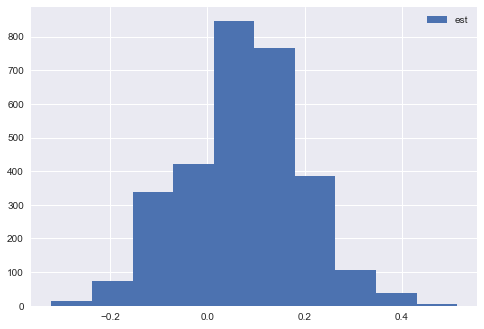

In [124]:
# To get the CATE at every X we call effect(X)
dml_effect = cate.effect(X)
plt.hist(dml_effect, label='est')
plt.legend()
plt.show()

In [125]:
# To get the parameter theta we call coef_. The first entry is the intercept of the CATE model
print(cate.coef_)
try:
    print(cate.effect_model.lasso_model.alpha_)
    plt.plot(cate.effect_model.lasso_model.alphas_, cate.effect_model.lasso_model.mse_path_)
    plt.show()
except:
    print("NA")

[-0.05707952 -0.1101906   0.12368182 -0.01630396  0.01638841  0.0206494
  0.14824186  0.04105756  0.10153722  0.15699125 -0.03017467  0.04778027
  0.08408015 -0.01652653 -0.00710907  0.05880703 -0.19192102 -0.15900693
  0.03517143 -0.16334309  0.02435382  0.05080503  0.07929768]
NA


In [126]:
# We can average the CATE to get an ATE
print("ATE Estimate: {:.3f}".format(np.mean(dml_effect)))

ATE Estimate: 0.072


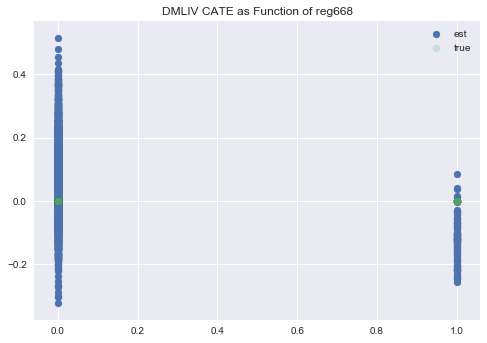

In [127]:
# We can also see how it compares to the true CATE at each target point and calculate MSE
plt.title("DMLIV CATE as Function of {}".format(X_df.columns[np.argmax(np.abs(cate.coef_[1:]))]))
plt.scatter(X[:, np.argmax(np.abs(cate.coef_[1:]))], dml_effect, label='est')
plt.scatter(X[:, np.argmax(np.abs(cate.coef_[1:]))], true_fn(X), label='true', alpha=.2)
plt.legend()
plt.show()

#### Some Diagnostics of the Fitted Nuisance Models Across Folds

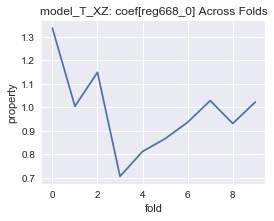

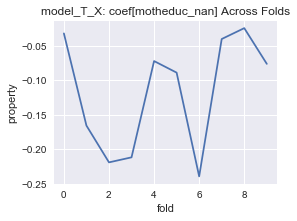

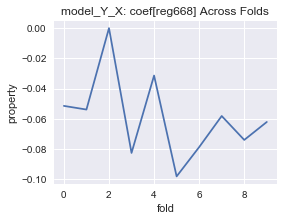

In [128]:
# The property .fitted_nuisances is a dictionary of the form:
# {'name_of_nuisance': [fitted_model_fold_1, fitted_model_fold_2, ...]}
# then we can access all properties of each of the fitted models for each fold.
# If for instance all nuisances have a linear form we can look at the standard deviation
# of the coefficients of each of the nuisance model across folds to check for stability
try:
    nuisance_diagnostic(cate, 'model_T_XZ', 'coef', lambda ns: ns.coef_.flatten(),
                        [c+"_0" for c in X_df.columns] + [c+"_1" for c in X_df.columns])
    nuisance_diagnostic(cate, 'model_T_X', 'coef', lambda ns: ns.coef_.flatten(), X_df.columns)
    nuisance_diagnostic(cate, 'model_Y_X', 'coef', lambda ns: ns.coef_.flatten(), X_df.columns)
except:
    print("Unavailable")

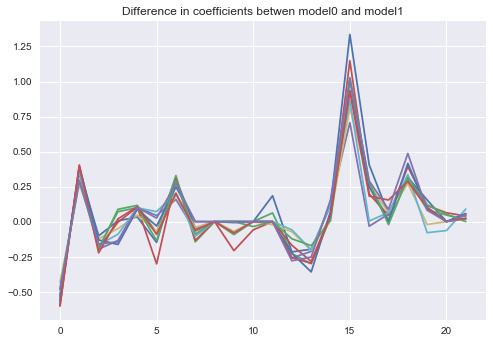

In [129]:
try:
    for i in range(N_SPLITS):
        plt.plot([c0 - c1 for c0, c1 in zip(cate.fitted_nuisances['model_T_XZ'][i].model0.coef_.flatten(),
              cate.fitted_nuisances['model_T_XZ'][i].model1.coef_.flatten())])
    
    plt.title("Difference in coefficients betwen model0 and model1")
    plt.show()
except:
    print("Unavailable")

# ATE via DRIV

In [130]:
from dml_iv import DMLIV
from dr_iv import DRIV, ProjectedDRIV
from utilities import SubsetWrapper, StatsModelLinearRegression, ConstantModel
from sklearn.dummy import DummyRegressor

np.random.seed(random_seed)

# For DRIV we need a model for predicting E[T*Z | X]. We use a classifier
model_TZ_X = lambda: model()

# We also need a model for the final regression that will fit the function theta(X)
# If we want to fit an ATE, we simply fit a constant functin theta(X) = theta
# We can do this with a pipeline where the preprocessing step only creates a bias column
# and the regression step fits a linear regression with no intercept.
# To get normal confidence intervals easily we can use a statsmodels linear regression
# wrapped in an sklearn interface
const_driv_model_effect = lambda: ConstantModel()

# As in OrthoDMLIV we need a perliminary estimator of the CATE.
# We use a DMLIV estimator with no cross-fitting (n_splits=1)
dmliv_prel_model_effect = DMLIV(model_Y_X(), model_T_X(), model_T_XZ(),
                                dmliv_model_effect(), dmliv_featurizer(),
                                n_splits=1, binary_instrument=True, binary_treatment=True)

const_dr_cate = DRIV(model_Y_X(), model_T_X(), model_Z_X(), # same as in DMLATEIV
                        dmliv_prel_model_effect, # preliminary model for CATE, must support fit(y, T, X, Z) and effect(X)
                        model_TZ_X(), # model for E[T * Z | X]
                        const_driv_model_effect(), # model for final stage of fitting theta(X)
                        cov_clip=COV_CLIP, # covariance clipping to avoid large values in final regression from weak instruments
                        n_splits=N_SPLITS, # number of splits to use for cross-fitting
                        binary_instrument=True, # a flag whether to stratify cross-fitting by instrument
                        binary_treatment=True # a flag whether to stratify cross-fitting by treatment
                       )

In [131]:
const_dr_cate.fit(y, T, X, Z, store_final=True)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 8 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


In [132]:
# To get the statsmodel summary we look at the effect_model, which is the pipeline, we then look
# at the reg step of the pipeline which is the statsmodel wrapper and then we look
# at the model attribute of the statsmodel wrapper and print the summary()
const_dr_cate.effect_model.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1554: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ess/self.df_model


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                      -0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                      -inf
Date:                Sat, 01 Jun 2019   Prob (F-statistic):                nan
Time:                        16:53:02   Log-Likelihood:                -5935.3
No. Observations:                2991   AIC:                         1.187e+04
Df Residuals:                    2990   BIC:                         1.188e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0718      0.032      2.231      0.026       0.009       0.135
==============================================================================
Omnibus:                     1560.900   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3111172.573
Skew:                           0.819   Prob(JB):                         0.00
Kurtosis:                     160.992   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Some diagnostics of the fitted nuisance models across folds

In [133]:
# The property .fitted_nuisances is a dictionary of the form:
# {'name_of_nuisance': [fitted_model_fold_1, fitted_model_fold_2, ...]}
# then we can access all properties of each of the fitted models for each fold.
# If for instance all nuisances have a linear form we can look at the standard deviation
# of the coefficients of each of the nuisance model across folds to check for stability
try:
    [print("Model {} max std of coefs: {}".format(name,
                                                  np.max(np.std([ns.coef_ for ns in nuisance_insts], axis=0)))) 
     if hasattr(nuisance_insts[0], 'coef_') else None
     for name, nuisance_insts in const_dr_cate.fitted_nuisances.items()]
except:
    print("Unavailable")

Model prel_model_effect max std of coefs: 0.08861170536431623
Model model_TZ_X max std of coefs: 0.1551255726963632
Model model_T_X max std of coefs: 0.07953278250754123
Model model_Z_X max std of coefs: 0.014391208119373949
Model model_Y_X max std of coefs: 0.026554847406610734


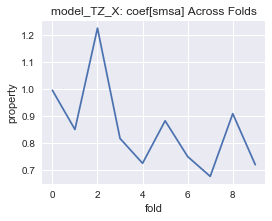

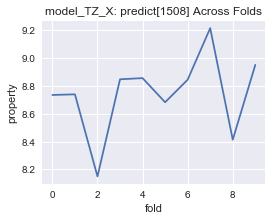

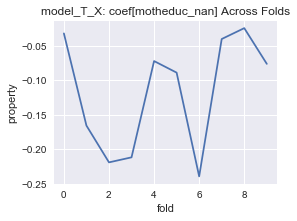

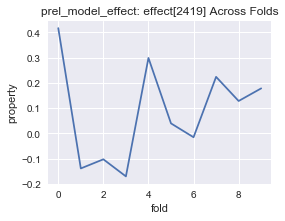

In [134]:
try:
    nuisance_diagnostic(const_dr_cate, 'model_TZ_X', 'coef', lambda ns: ns.coef_.flatten(), X_df.columns)
    nuisance_diagnostic(const_dr_cate, 'model_TZ_X', 'predict', lambda ns: ns.predict(X), np.arange(X.shape[0]))
    nuisance_diagnostic(const_dr_cate, 'model_T_X', 'coef', lambda ns: ns.coef_.flatten(), X_df.columns)
    nuisance_diagnostic(const_dr_cate, 'prel_model_effect', 'effect', lambda ns: ns.effect(X), np.arange(X.shape[0]))
except:
    print("Unavailable")

## Projecting CATE to a pre-chosen subset of variables in final model

In [135]:
from dml_iv import DMLIV
from dr_iv import DRIV, ProjectedDRIV
from utilities import SubsetWrapper

np.random.seed(random_seed)

# We could also fit a projection on a subset of the features by using the
# subset wrapper from our utilities.

# Example: including everything for expository purposes, but any array-like of indices would work
subset_names = set(['motheduc'])
# list of indices of features X to use in the final model
feature_inds = np.argwhere([(x in subset_names) for x in X_df.columns.values]).flatten()
print(feature_inds)
# Because we are projecting to a low dimensional model space, we can
# do valid inference and we can use statsmodel linear regression to get all
# the hypothesis testing capability
proj_driv_model_effect = lambda: SubsetWrapper(StatsModelLinearRegression(),
                                          feature_inds # list of indices of features X to use in the final model
                                         )

[4]


In [136]:
proj_dr_cate = const_dr_cate.refit_final(proj_driv_model_effect())

In [137]:
# To get the CATE at every X we call effect(X[:, feature_inds])
proj_dr_effect = proj_dr_cate.effect(X[:, feature_inds])

In [138]:
# To get the statsmodel summary we look at the effect_model, which is
# an instance of SubsetWrapper, we look at the model of the SubsetWrapper which is 
# and instance of the pipeline, we then look at the reg step of the pipeline which is the statsmodel wrapper and
# call summary() of the wrapper (most prob there is a better API for this, but we can go with this for now :)
proj_dr_cate.effect_model.summary(alpha=.05, xname=['const']+list(X_df.columns[feature_inds]))

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.316
Date:                Sat, 01 Jun 2019   Prob (F-statistic):             0.0120
Time:                        16:53:03   Log-Likelihood:                -5932.2
No. Observations:                2991   AIC:                         1.187e+04
Df Residuals:                    2989   BIC:                         1.188e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0726      0.032      2.257      0.024       0.010       0.136
motheduc      -0.0815      0.032     -2.513      0.012      -0.145      -0.018
==============================================================================
Omnibus:                     1570.882   Durbin-Watson:                   1.972
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3062292.770
Skew:                           0.842   Prob(JB):                         0.00
Kurtosis:                     159.746   Cond. No.                         1.01
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

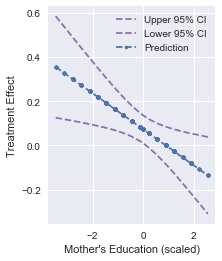

In [139]:
# We can also evaluate coverage and create prediction intervals using statsmodels attributes
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
res = proj_dr_cate.effect_model.model
predictions = res.get_prediction(PolynomialFeatures(degree=1, include_bias=True).fit_transform(X[:, feature_inds]))
frame = predictions.summary_frame(alpha=0.05)
pred = frame['mean']
iv_l = frame['mean_ci_lower']
iv_u = frame['mean_ci_upper']

fig, ax = plt.subplots(figsize=(3,4))
order = np.argsort(X[:, feature_inds[0]])
ax.plot(X[order, feature_inds[0]], iv_u[order], 'C3--', label="Upper 95% CI")
ax.plot(X[order, feature_inds[0]], iv_l[order], 'C3--', label="Lower 95% CI")
ax.plot(X[order, feature_inds[0]], pred[order], 'C0--.', label="Prediction")
ax.legend(loc='best')
plt.xlabel("Mother's Education (scaled)")
plt.ylabel("Treatment Effect")
#plt.savefig("NLSYM_momeduc_linear_projection_2.pdf", dpi=300, bbox_inches='tight')
plt.show()

## Random Forest Based CATE and Tree Explainer

In [140]:
from dml_iv import DMLIV
from dr_iv import DRIV, ProjectedDRIV
from utilities import SubsetWrapper
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

np.random.seed(random_seed)

rf_driv_model_effect = lambda: RandomForestRegressor(n_estimators=5000, max_depth=2, min_impurity_decrease=0.01,
                                                     min_samples_leaf=100, bootstrap=True)

In [141]:
rf_dr_cate = const_dr_cate.refit_final(rf_driv_model_effect())

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


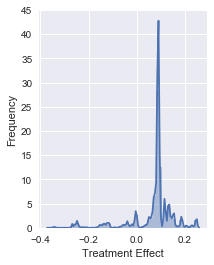

In [142]:
import seaborn as sns

rf_dr_effect = rf_dr_cate.effect(X)
plt.figure(figsize=(3,4))
sns.distplot(rf_dr_effect)
plt.xlabel("Treatment Effect")
plt.ylabel("Frequency")
plt.savefig("NLSYM_hte_distribution_2.pdf", dpi=300, bbox_inches='tight')
plt.show()

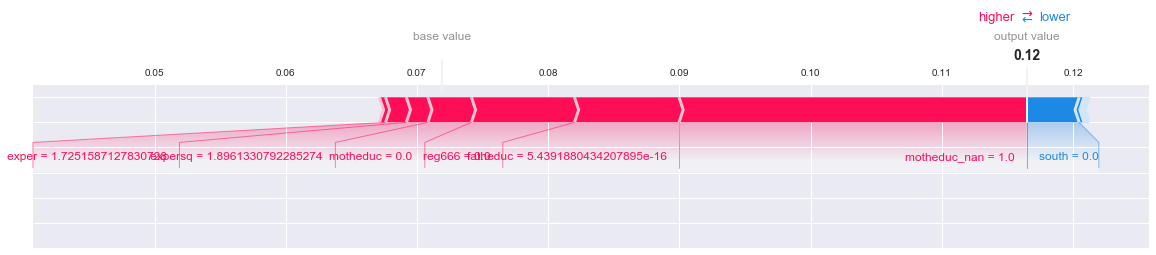

In [143]:
import shap
import pandas as pd

Xdf = pd.DataFrame(X, columns=X_df.columns)
# explain the model's predictions using SHAP values
explainer = shap.TreeExplainer(rf_dr_cate.effect_model)
shap_values = explainer.shap_values(Xdf)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], Xdf.iloc[0,:], matplotlib=True)

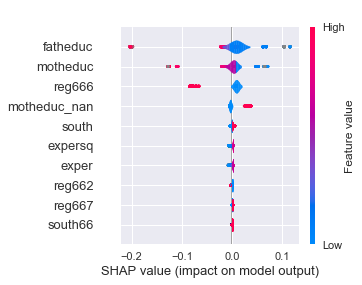

In [183]:
plt.figure(figsize=(4,4))
shap.summary_plot(shap_values, Xdf, plot_type="violin", max_display=10, show=False, auto_size_plot=False)
plt.savefig("NLSYM_shap_summary_violin_2.pdf", dpi=300, bbox_inches='tight')
plt.show()

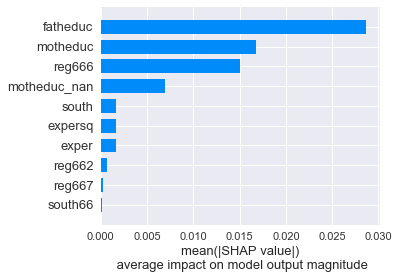

In [145]:
plt.figure(figsize=(5,4))
shap.summary_plot(shap_values, Xdf, plot_type='bar', max_display=10, show=False, auto_size_plot=False)
plt.xlabel("mean(|SHAP value|)\n average impact on model output magnitude")
plt.savefig("NLSYM_shap_summary_bar.pdf", dpi=300, bbox_inches='tight')
plt.show()